In [122]:
!pip install cvxpy


In [1]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
matplotlib.use('Agg')
import datetime

%matplotlib inline
from finrl.config_tickers import DOW_30_TICKER
from finrl.meta.preprocessor.yahoodownloader import YahooDownloader
from finrl.meta.preprocessor.preprocessors import FeatureEngineer, data_split
from stock_env import StockTradingEnv
from finrl.agents.stablebaselines3.models import DRLAgent,DRLEnsembleAgent
from finrl.plot import backtest_stats, backtest_plot, get_daily_return, get_baseline,trx_plot

from pprint import pprint
import scienceplots
import sys
sys.path.append("../FinRL-Library")

plt.style.use('science')

In [4]:
import os
from finrl.main import check_and_make_directories
from finrl.config import (
    DATA_SAVE_DIR,
    TRAINED_MODEL_DIR,
    TENSORBOARD_LOG_DIR,
    RESULTS_DIR,
    INDICATORS,
    TRAIN_START_DATE,
    TRAIN_END_DATE,
    TEST_START_DATE,
    TEST_END_DATE,
    TRADE_START_DATE,
    TRADE_END_DATE,
)

check_and_make_directories([DATA_SAVE_DIR, TRAINED_MODEL_DIR, TENSORBOARD_LOG_DIR, RESULTS_DIR])

In [5]:
import yahoo_fin.stock_info as si
ticks = si.tickers_ftse100(True)
sp500 = si.tickers_sp500(True)
dow = si.tickers_dow(True)
nifty = si.tickers_nifty50(True)
display(ticks.head(100))


Warning - Certain functionality 
             requires requests_html, which is not installed.
             
             Install using: 
             pip install requests_html
             
             After installation, you may have to restart your Python session.


,Company,Ticker,FTSE industry classification benchmark sector[25]
0,3i,III,Financial services
1,Admiral Group,ADM,Insurance
2,Airtel Africa,AAF,Telecommunications services
3,Anglo American plc,AAL,Mining
4,Antofagasta plc,ANTO,Mining
...,...,...,...
95,Vistry Group,VTY,Home Construction
96,Vodafone Group,VOD,Mobile telecommunications
97,Weir Group,WEIR,Industrial goods and services
98,Whitbread,WTB,Retail hospitality


In [6]:
ticks_from_setctors = ticks.groupby('FTSE industry classification benchmark sector[25]',as_index=False).first().iloc[:,[2]]
ticks['FTSE industry classification benchmark sector[25]'].value_counts()

FTSE industry classification benchmark sector[25]
Financial services                                    7
Support services                                      7
Media                                                 6
Banks                                                 5
Household goods & home construction                   5
Mining                                                5
Pharmaceuticals & biotechnology                       4
Life insurance                                        4
Travel & leisure                                      4
Multiline utilities                                   4
Real estate investment trusts                         3
Food & drug retailing                                 3
Aerospace & defence                                   3
Retailers                                             3
Oil & gas producers                                   2
Tobacco                                               2
Telecommunications services                           

In [7]:
ticks_from_setctors

,Ticker
0,BA
1,BARC
2,CCH
3,CRDA
4,FCIT
5,MNDI
6,SSE
7,HLMA
8,III
9,MKS


In [176]:
TRAIN_START_DATE = '2010-01-01'
TRAIN_END_DATE = '2023-12-30'
TEST_START_DATE = '2024-01-01'
TEST_END_DATE = '2024-10-01'

In [19]:

symbols = ['AZN','ADM','BA','BP','VOD','SAP','NOK']
df = YahooDownloader(start_date = TRAIN_START_DATE,
                     end_date = TEST_END_DATE,
                     ticker_list = symbols).fetch_data()


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

Shape of DataFrame:  (25970, 8)


In [20]:
from finrl.config_tickers import DOW_30_TICKER,NAS_100_TICKER,HSI_50_TICKER,DAX_30_TICKER

df_dow = YahooDownloader(start_date = TRAIN_START_DATE,
                     end_date = TEST_END_DATE,
                     ticker_list = DOW_30_TICKER).fetch_data()
df_nasdaq = YahooDownloader(start_date = TRAIN_START_DATE,
                     end_date = TEST_END_DATE,
                     ticker_list = NAS_100_TICKER).fetch_data()
df_hsi = YahooDownloader(start_date = TRAIN_START_DATE,
                     end_date = TEST_END_DATE,
                     ticker_list = HSI_50_TICKER).fetch_data()
df_dax = YahooDownloader(start_date = TRAIN_START_DATE,
                     end_date = TEST_END_DATE,
                     ticker_list = DAX_30_TICKER).fetch_data()

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

Shape of DataFrame:  (108983, 8)



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

1 Failed download:
['XLNX']: YFTzMissingError('$%ticker%: possibly delisted; No timezone found')
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

1 F

Shape of DataFrame:  (322496, 8)


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

Shape of DataFrame:  (177038, 8)


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

1 Failed download:
['DAI.DE']: YFTzMissingError('$%ticker%: possibly delisted; No timezone found')
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

1 

Shape of DataFrame:  (100708, 8)


In [23]:
df_dow.to_csv('./data/dow.csv')
df_nasdaq.to_csv('./data/nasdaq.csv')
df_hsi.to_csv('./data/hsi.csv')
df_dax.to_csv('./data/dax.csv')


In [3]:
from pandas import read_csv


df_dow =read_csv('./data/dow.csv')
df_nasdaq =read_csv('./data/nasdaq.csv')
df_hsi = read_csv('./data/hsi.csv')
df_dax = read_csv('./data/dax.csv')

In [4]:
ticks_list = df_dow['tic'].unique()

In [25]:
df_copy = df_dow.copy()
df_copy['symbol'] = df_dow['tic']
df_copy.head()
df_close = df_copy[['symbol','close','date']]
df_close.head()

,symbol,close,date
0,AAPL,6.454506,2010-01-04
1,AMGN,40.915886,2010-01-04
2,AXP,32.906181,2010-01-04
3,BA,43.777546,2010-01-04
4,CAT,40.027210,2010-01-04


In [26]:
pivot = df_close.pivot(index='date',values='close',columns='symbol')

pivot.head()

symbol,AAPL,AMGN,AXP,BA,CAT,CRM,CSCO,CVX,DIS,DOW,...,MRK,MSFT,NKE,PG,TRV,UNH,V,VZ,WBA,WMT
date,,,,,,,,,,,,,,,,,,,,,
2010-01-04,6.454506,40.915886,32.906181,43.777546,40.027210,18.622328,16.475370,44.045532,27.715311,NaN,...,21.558409,23.347326,13.647313,39.663857,35.008789,25.299866,19.822807,14.697927,23.392054,13.113418
2010-01-05,6.465664,40.561455,32.833805,45.211334,40.505768,18.542681,16.401968,44.357536,27.646175,NaN,...,21.645786,23.354858,13.701604,39.676823,34.179432,25.259739,19.595650,14.724429,23.203924,12.982835
2010-01-06,6.362819,40.256641,33.364540,46.582806,40.628819,18.510326,16.295198,44.363091,27.499260,NaN,...,21.937040,23.211538,13.618073,39.488628,33.694481,25.508492,19.332523,14.301045,23.028326,12.953817
2010-01-07,6.351058,39.888027,33.905670,48.468555,40.792885,18.428192,16.368605,44.195957,27.507898,NaN,...,21.971994,22.970144,13.751725,39.274494,34.179432,26.487425,19.512436,14.215919,23.166283,12.961074
2010-01-08,6.393281,40.242458,33.881458,48.001007,41.250923,18.455570,16.455355,44.273952,27.551111,NaN,...,21.960333,23.128559,13.724578,39.222576,34.130222,26.238686,19.566416,14.224875,23.197649,12.895782


In [27]:
pivot[pivot.index>'2010-01-01'].plot(figsize=(10,4))

<Axes: xlabel='date'>

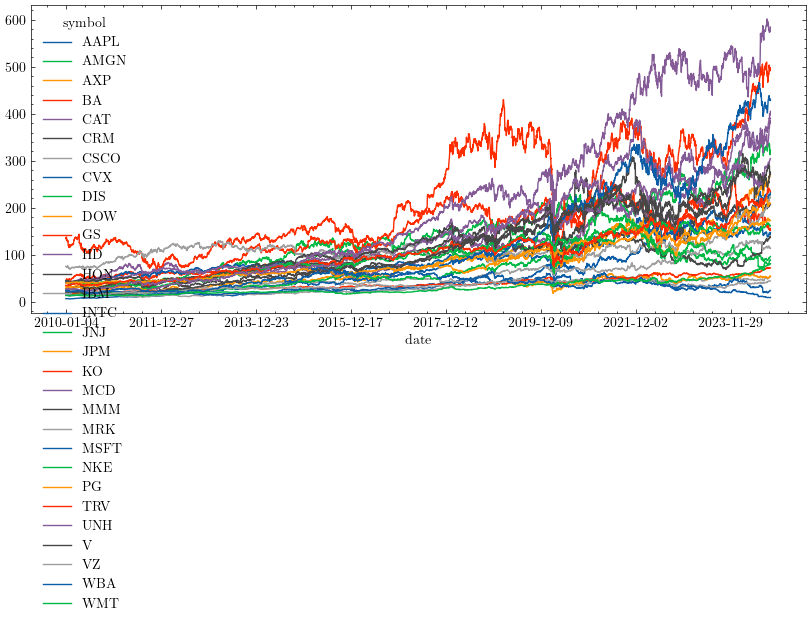

In [30]:
%matplotlib inline
plt.show()


In [32]:
df_dow.head()
df = df_dow.copy()

In [33]:
data = df.sort_values(['date','tic'],ignore_index=True)
data.index = data.index.factorize()[0]

In [34]:
df.head()
df.dropna(inplace=True)

In [35]:
INDICATORS = [
    "close_21_sma",
]
fe = FeatureEngineer(use_technical_indicator=True,
                     tech_indicator_list = INDICATORS,
                     use_turbulence=False,
                     user_defined_feature = False)

processed = fe.preprocess_data(df)
processed = processed.copy()
processed = processed.fillna(0)
processed = processed.replace(np.inf,0)

Successfully added technical indicators


In [38]:
processed.head(100)


,Unnamed: 0,date,open,high,low,close,volume,tic,day,close_21_sma
0,0,2010-01-04,7.622500,7.660714,7.585000,6.454506,493729600,AAPL,0,6.454506
3710,1,2010-01-04,56.630001,57.869999,56.560001,40.915886,5277400,AMGN,0,40.915886
7420,2,2010-01-04,40.810001,41.099998,40.389999,32.906181,6894300,AXP,0,32.906181
11130,3,2010-01-04,55.720001,56.389999,54.799999,43.777546,6186700,BA,0,43.777546
14840,4,2010-01-04,57.650002,59.189999,57.509998,40.027210,7325600,CAT,0,40.027210
...,...,...,...,...,...,...,...,...,...,...
29683,95,2010-01-07,31.770000,31.860001,31.540001,27.507898,8202100,DIS,3,27.592161
33393,96,2010-01-07,174.320007,178.750000,173.949997,137.520828,8727400,GS,3,135.676739
37103,97,2010-01-07,28.860001,29.219999,28.730000,20.481888,12058200,HD,3,20.300774
40813,98,2010-01-07,38.554264,39.431362,38.211052,28.460951,10266533,HON,3,28.043119


In [39]:
train_data = data_split(processed, TRAIN_START_DATE, TRAIN_END_DATE)
test_data = data_split(processed, TEST_START_DATE, TEST_END_DATE)

In [40]:
display(train_data.tail(5))

,Unnamed: 0,date,open,high,low,close,volume,tic,day,close_21_sma
3521,103338,2023-12-29,525.979980,528.239990,523.919983,520.342346,2080100,UNH,4,529.433409
3521,103339,2023-12-29,260.570007,261.459991,259.670013,258.866302,4074600,V,4,256.412733
3521,103340,2023-12-29,37.380001,37.759998,37.320000,35.344772,16205200,VZ,4,35.421116
3521,103341,2023-12-29,26.440001,26.629999,25.750000,24.868887,10853300,WBA,4,22.905900
3521,103342,2023-12-29,52.509998,52.693333,52.386665,52.042637,21948300,WMT,4,50.952245


In [41]:
print(len(train_data))
print(len(test_data))

102138
5452


In [42]:
stock_dimension = len(train_data.tic.unique())
state_space = 1 + 2*stock_dimension + len(INDICATORS)*stock_dimension
print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")

Stock Dimension: 29, State Space: 88


In [61]:
# Parameters for the environment
# env_kwargs = {
#     "hmax": 100, 
#     "num_stock_shares": [0] * stock_dimension,
#     "initial_amount": 1000000, 
#     "buy_cost_pct": [0.001] * stock_dimension,
#     "sell_cost_pct": [0.001] * stock_dimension,
#     "state_space": state_space, 
#     "stock_dim": stock_dimension, 
#     "tech_indicator_list": INDICATORS, 
#     "action_space": stock_dimension, 
#     "reward_scaling": 1e-4,
#     "make_plots" : True
    
# }
env_kwargs = {
    "hmax": 100, 
    "num_stock_shares": [0] * stock_dimension,
    "initial_amount": 1000000, 
    "buy_cost_pct": [0.001] * stock_dimension,
    "sell_cost_pct": [0.001] * stock_dimension,
    "state_space": state_space, 
    "stock_dim": stock_dimension, 
    "tech_indicator_list": INDICATORS, 
    "action_space": stock_dimension, 
    "reward_scaling": 1e-4,
    "make_plots" : False
    
}

#Establish the training environment using StockTradingEnv() class
e_train_gym = StockTradingEnv(df = train_data, **env_kwargs)

In [62]:
agent = DRLAgent(env = e_train_gym)
PPO_PARAMS = {
    "n_steps": 2048,
    "ent_coef": 0.01,
    "learning_rate": 0.00025,
    "batch_size": 128,
}
model_ppo = agent.get_model("ppo",model_kwargs = PPO_PARAMS)

{'n_steps': 2048, 'ent_coef': 0.01, 'learning_rate': 0.00025, 'batch_size': 128}
Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


In [63]:
ppo_agernt = agent.train_model(model=model_ppo, 
                             tb_log_name='ppo',
                             total_timesteps=50000)

----------------------------------
| time/              |           |
|    fps             | 84        |
|    iterations      | 1         |
|    time_elapsed    | 24        |
|    total_timesteps | 2048      |
| train/             |           |
|    reward          | 0.5295626 |
----------------------------------
----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 3.52e+03   |
|    ep_rew_mean          | 195        |
| time/                   |            |
|    fps                  | 78         |
|    iterations           | 2          |
|    time_elapsed         | 52         |
|    total_timesteps      | 4096       |
| train/                  |            |
|    approx_kl            | 0.01722652 |
|    clip_fraction        | 0.179      |
|    clip_range           | 0.2        |
|    entropy_loss         | -41.2      |
|    explained_variance   | -0.0341    |
|    learning_rate        | 0.00025    |
|    loss                 | 3

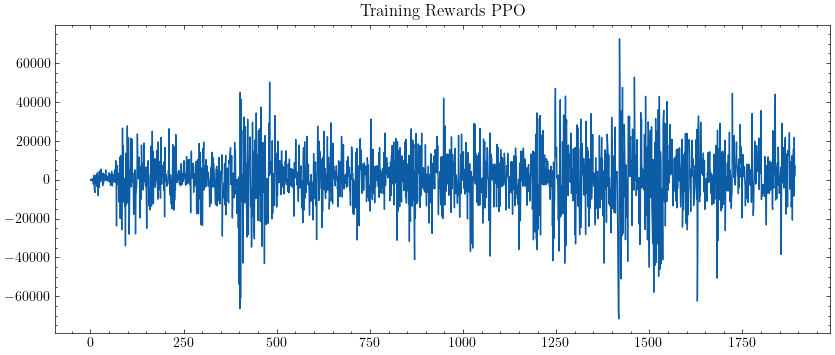

In [70]:
rewards_ppo = e_train_gym.rewards_memory
plt.title('Training Rewards PPO')
plt.plot(range(0,len(e_train_gym.rewards_memory)),e_train_gym.rewards_memory)

In [73]:
columns = ['acc_value']
columns.extend(train_data.tic.unique())
columns.extend(train_data.tic.unique() + ['_holding'])
columns.extend(train_data.tic.unique()+['_ma'])

In [112]:
states_ppo_dates = e_train_gym.date_memory
states_ppo = e_train_gym.state_memory
states_ppo[51000]


[50042.84562946598,
 26.97542762756348,
 129.49806213378906,
 53.91514587402344,
 122.71998596191406,
 71.58256530761719,
 70.31783294677734,
 23.52583694458008,
 71.82817077636719,
 85.91336822509766,
 141.6511993408203,
 104.17294311523438,
 87.95378112792969,
 102.2322998046875,
 29.955041885375977,
 95.11338806152344,
 54.33667755126953,
 32.388893127441406,
 95.2667999267578,
 106.82648468017578,
 46.918739318847656,
 51.34152603149414,
 47.50179672241211,
 70.92581176757812,
 95.9395751953125,
 119.15866088867188,
 77.4411392211914,
 33.338314056396484,
 56.60984802246094,
 19.596296310424805,
 0.0,
 0.0,
 766.0,
 4533.0,
 691.0,
 0.0,
 547.0,
 3758.0,
 171.0,
 66.0,
 391.0,
 726.0,
 434.0,
 255.0,
 135.0,
 298.0,
 0.0,
 4847.0,
 102.0,
 101.0,
 2039.0,
 225.0,
 72.0,
 62.0,
 803.0,
 483.0,
 4956.0,
 70.0,
 721.0,
 26.319650650024414,
 133.58929806663878,
 56.20623270670573,
 121.12253098260788,
 70.48474629720052,
 71.6277335030692,
 24.25176039196196,
 71.82070087251209,
 87.10

In [120]:
states_ppo = e_train_gym.state_memory
states_ppo_dates = e_train_gym.date_memory
states = np.array(states_ppo)
z2 = pd.DataFrame(states,columns= columns)
holdings = np.array(z2.iloc[:,1:stock_dimension+1]) * np.array(z2.iloc[:,stock_dimension+2 :2*(stock_dimension+1)])
hoding_df = pd.DataFrame(holdings,columns=z2.columns[1:stock_dimension+1].tolist())
total_portfolio_value = holdings.sum(axis=1).reshape(-1, 1)

ppo_weights = holdings /total_portfolio_value
weights_df = pd.DataFrame(ppo_weights, columns=z2.columns[1:stock_dimension + 1].tolist())



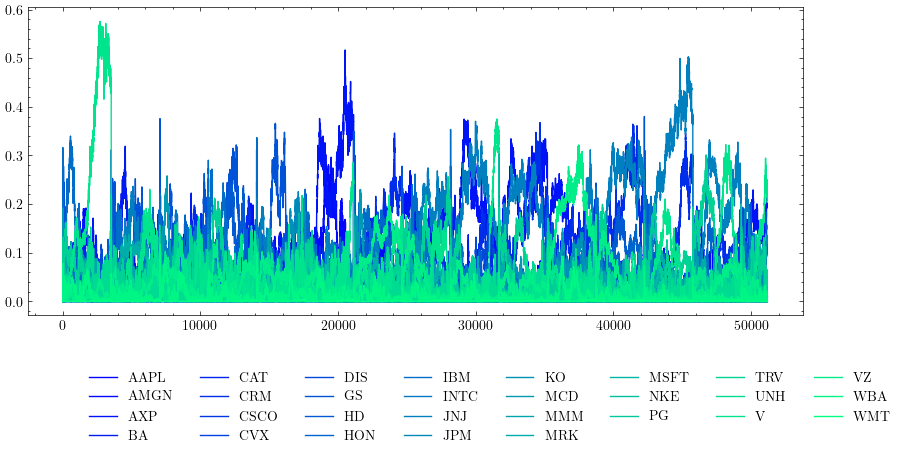

In [121]:
weights_df.plot(colormap="winter").legend(ncol=8,bbox_transform=plt.gcf().transFigure, bbox_to_anchor=(1,0))

In [195]:
# add covariance matrix as states
df = df_dow.copy()
df = df.sort_values(['date', 'tic'], ignore_index=True)
df.index = df.date.factorize()[0]

df["pct_change"] = df.groupby("tic").close.pct_change()

cov_list = []
# look back is one year
lookback = 252
for i in range(lookback, len(df.index.unique())):
    data_lookback = df.loc[i-lookback:i, :]
    price_lookback = data_lookback.pivot_table(
        index='date', columns='tic', values='close')
    return_lookback = price_lookback.pct_change().dropna()
    covs = return_lookback.cov().values
    cov_list.append(covs)


KeyError: 'date'

In [198]:
df["mean_pct_change_lookback"] = df.rolling(lookback)["pct_change"].mean()
df["ewm_returns"] = df["pct_change"].ewm(span=50).mean()
df_cov = pd.DataFrame(
    {'time': df.date.unique()[lookback:], 'cov_list': cov_list})
df = df.merge(df_cov, left_on='date',right_on='time')
df = df.sort_values(['date', 'tic']).reset_index(drop=True)

In [159]:
df.head(3)

,Unnamed: 0,date,open,high,low,close,volume,tic,day,close_21_sma,pct_change,mean_pct_change_lookback,ewm_returns,cov_list
0,7308,2011-01-03,11.630000,11.795000,11.601429,9.939778,445138400,AAPL,0,9.719666,0.021733,0.000879,0.000865,"[[0.000284962291322476, 9.196054051092536e-05,..."
1,7309,2011-01-03,55.200001,56.279999,55.180000,39.377647,5453300,AMGN,0,39.304061,0.011840,0.000915,0.001296,"[[0.000284962291322476, 9.196054051092536e-05,..."
2,7310,2011-01-03,43.299999,43.619999,43.110001,35.531185,7633300,AXP,0,36.196670,0.011183,0.000965,0.001683,"[[0.000284962291322476, 9.196054051092536e-05,..."


In [211]:

from agents.evn_mvo import StockPortfolioEnv
from agents.mvo_agent import MarkowitzAgent


test_df = data_split(
    df,
    start=TEST_START_DATE,
    end=TEST_END_DATE
)

stock_dimension = len(test_df.tic.unique())
state_space = stock_dimension + len(INDICATORS)
print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")

env_kwargs = {
    "hmax": 100,
    "initial_amount": 1000,
    "transaction_cost_pct": 0.001,
    "state_space": state_space,
    "stock_dim": stock_dimension,
    "tech_indicator_list": INDICATORS,
    "action_space": stock_dimension,
    "reward_scaling": 1e-4

}
e_test_gym = StockPortfolioEnv(df=test_df, **env_kwargs)
agent = MarkowitzAgent(e_test_gym)
markowitz_history_df = agent.prediction(e_test_gym)
markowitz_history_df["method"] = "markowitz"

Stock Dimension: 30, State Space: 31


KeyError: 'close_21_sma'

In [46]:
e_test_gym = StockTradingEnv(df = test_data, **env_kwargs)

hit end!


<Figure size 350x262.5 with 0 Axes>

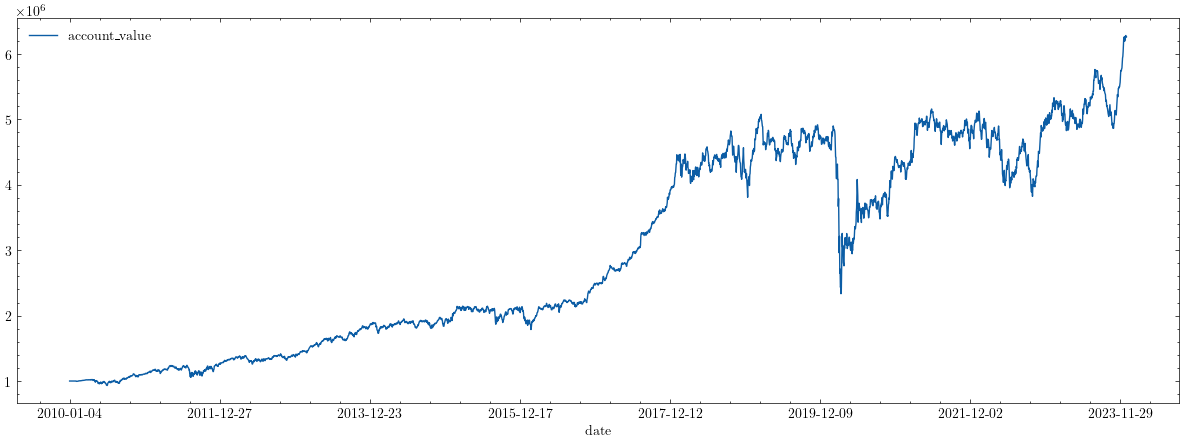

hit end!


<Axes: xlabel='date'>

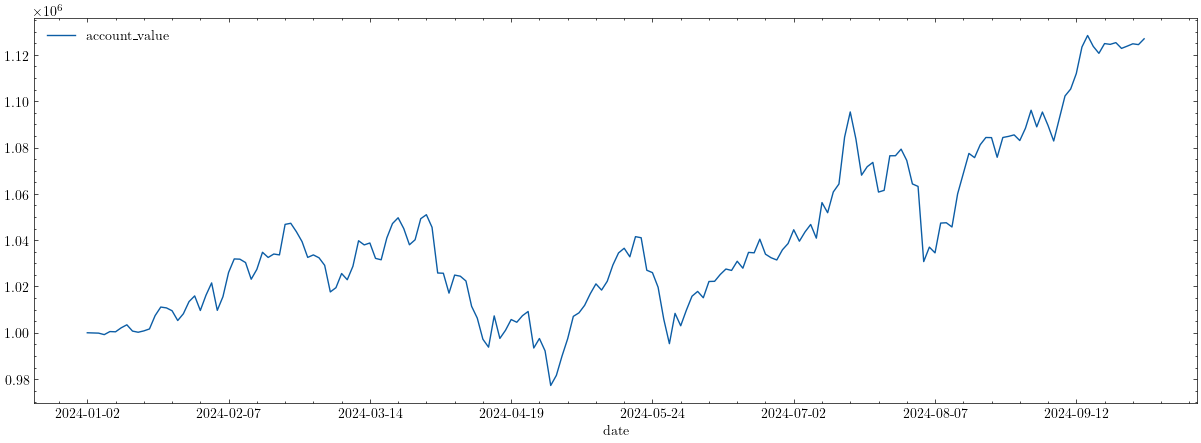

In [47]:
df_account_value_ppo_train, df_actions_ppo = DRLAgent.DRL_prediction(
    model=ppo_agernt, 
    environment = e_train_gym)


hit end!


<Axes: xlabel='date'>

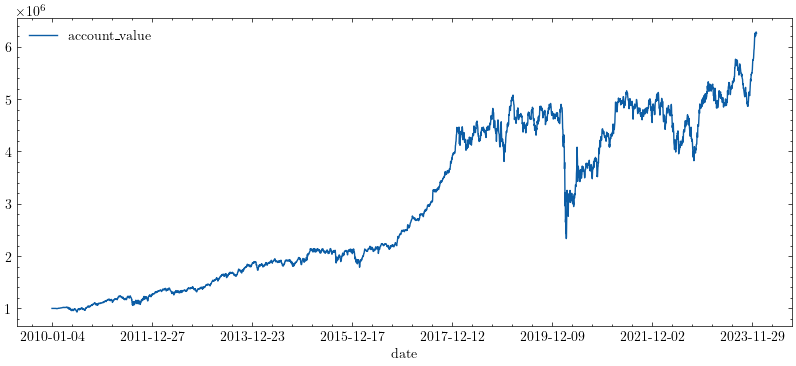

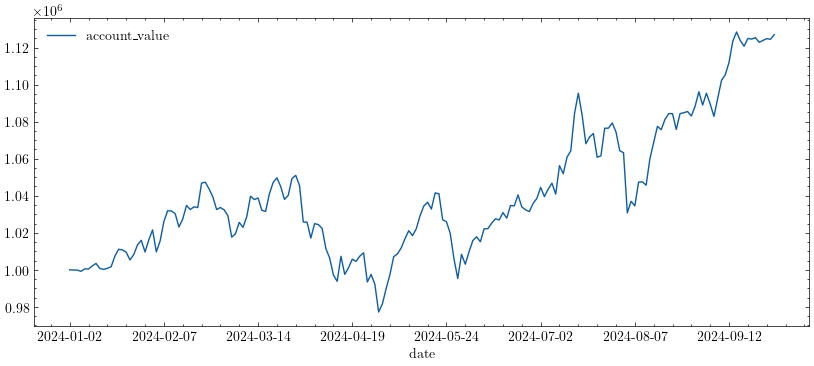

In [53]:
df_result_ppo = df_account_value_ppo_train.set_index(df_account_value_ppo_train.columns[0])
plt.rcParams["figure.figsize"] = (10,4)
df_result_ppo.plot()
df_account_value_ppo_test, df_actions_ppo = DRLAgent.DRL_prediction(
    model=ppo_agernt, 
    environment = e_test_gym)
df_result_ppo = df_account_value_ppo_test.set_index(df_account_value_ppo_test.columns[0])
plt.rcParams["figure.figsize"] = (10,4)
df_result_ppo.plot()

In [59]:
e_train_gym.rewards_memory

[]

In [48]:
backtest_stats(df_account_value_ppo_train)

Annual return          0.140229
Cumulative returns     5.259409
Annual volatility      0.212230
Sharpe ratio           0.725599
Calmar ratio           0.259640
Stability              0.925054
Max drawdown          -0.540091
Omega ratio            1.153528
Sortino ratio          1.020412
Skew                        NaN
Kurtosis                    NaN
Tail ratio             1.013090
Daily value at risk   -0.026127
dtype: float64


Annual return          0.140229
Cumulative returns     5.259409
Annual volatility      0.212230
Sharpe ratio           0.725599
Calmar ratio           0.259640
Stability              0.925054
Max drawdown          -0.540091
Omega ratio            1.153528
Sortino ratio          1.020412
Skew                        NaN
Kurtosis                    NaN
Tail ratio             1.013090
Daily value at risk   -0.026127
dtype: float64

In [98]:
backtest_stats(df_account_value_ppo_test)

Annual return          0.038219
Cumulative returns     0.025320
Annual volatility      0.172747
Sharpe ratio           0.304434
Calmar ratio           0.417120
Stability              0.061250
Max drawdown          -0.091625
Omega ratio            1.056229
Sortino ratio          0.424850
Skew                        NaN
Kurtosis                    NaN
Tail ratio             0.959337
Daily value at risk   -0.021555
dtype: float64


Annual return          0.038219
Cumulative returns     0.025320
Annual volatility      0.172747
Sharpe ratio           0.304434
Calmar ratio           0.417120
Stability              0.061250
Max drawdown          -0.091625
Omega ratio            1.056229
Sortino ratio          0.424850
Skew                        NaN
Kurtosis                    NaN
Tail ratio             0.959337
Daily value at risk   -0.021555
dtype: float64

[*********************100%%**********************]  1 of 1 completed

Shape of DataFrame:  (167, 8)


<Axes: >

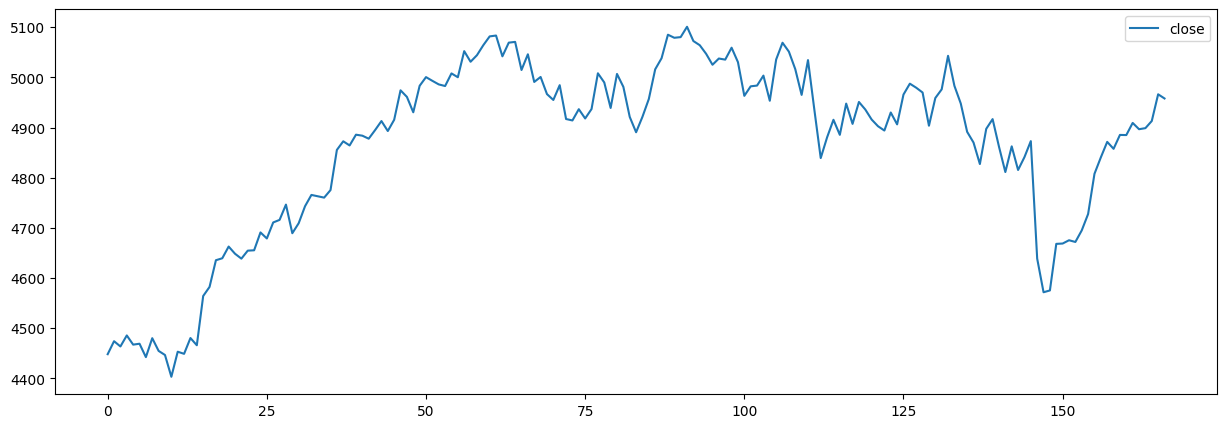

In [100]:
index_df = YahooDownloader(start_date = TEST_START_DATE,
                     end_date = TEST_END_DATE,
                     ticker_list = ['^STOXX50E']).fetch_data()
index_df = index_df[['date','close']]
fst_day = index_df['close'][0]
dji = pd.merge(index_df['date'], index_df['close'].div(fst_day).mul(1000000), 
               how='outer', left_index=True, right_index=True).set_index('date')
index_df.plot()

[*********************100%%**********************]  1 of 1 completed

Shape of DataFrame:  (3513, 8)


<Axes: >

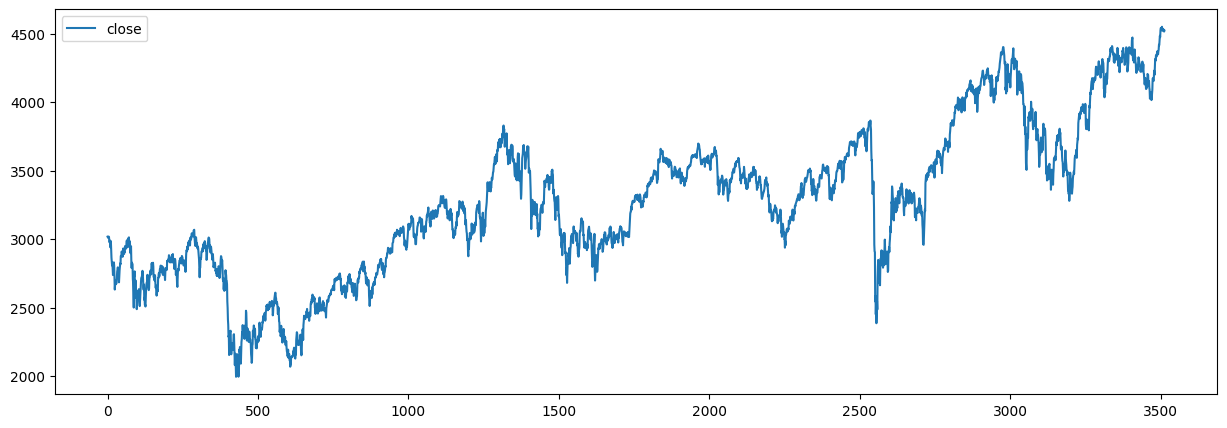

In [102]:
index_df = YahooDownloader(start_date = TRAIN_START_DATE,
                     end_date = TRAIN_END_DATE,
                     ticker_list = ['^STOXX50E']).fetch_data()
index_df = index_df[['date','close']]
fst_day = index_df['close'][0]
dji = pd.merge(index_df['date'], index_df['close'].div(fst_day).mul(1000000), 
               how='outer', left_index=True, right_index=True).set_index('date')
index_df.plot()

In [103]:
def DRL_prediction(model, environment, deterministic=True):
    """make a prediction and get results"""
    test_env, test_obs = environment.get_sb_env()
    account_memory = None  # This help avoid unnecessary list creation
    actions_memory = None  # optimize memory consumption
    state_memory= []

    test_env.reset()
    max_steps = len(environment.df.index.unique()) - 1

    for i in range(len(environment.df.index.unique())):
        action, _states = model.predict(test_obs, deterministic=deterministic)
        # account_memory = test_env.env_method(method_name="save_asset_memory")
        # actions_memory = test_env.env_method(method_name="save_action_memory")
        test_obs, rewards, dones, info = test_env.step(action)
        state_memory.append(test_obs[0])

        if (
            i == max_steps - 1
        ):  # more descriptive condition for early termination to clarify the logic
            account_memory = test_env.env_method(method_name="save_asset_memory")
            actions_memory = test_env.env_method(method_name="save_action_memory")
        # add current state to state memory
        # state_memory=test_env.env_method(method_name="save_state_memory")

        if dones[0]:
            print("hit end!")
            break
    return account_memory[0], actions_memory[0],state_memory

In [104]:
df_account_value_ppo_test, df_actions_ppo, states = DRL_prediction(
    model=ppo_agernt, 
    environment = e_test_gym)

hit end!


In [105]:
columns = ['acc_value']
columns.extend(train_data.tic.unique())
columns.extend(train_data.tic.unique() + ['_holding'])
columns.extend(train_data.tic.unique()+['_ma'])

print(len(columns))

22


In [114]:
states = np.array(states)
z = pd.DataFrame(states,columns= columns)
z.head()

,acc_value,ADM,AZN,BA,BP,NOK,SAP,VOD,ADM_holding,AZN_holding,...,NOK_holding,SAP_holding,VOD_holding,ADM_ma,AZN_ma,BA_ma,BP_ma,NOK_ma,SAP_ma,VOD_ma
0,987373.5000,71.248657,66.875084,243.910004,34.646816,3.290370,147.933578,8.427602,18.0,0.0,...,0.0,22.0,0.0,71.645844,63.820744,243.725662,34.138023,3.242162,153.708771,8.354484
1,974955.1875,69.904167,67.325356,244.940002,34.415836,3.348606,146.679321,8.522722,36.0,0.0,...,0.0,44.0,0.0,71.585434,63.983559,244.633331,34.134171,3.237633,153.551422,8.355597
2,962566.8125,68.988342,66.933815,249.000000,34.675690,3.338900,147.992844,8.541746,54.0,0.0,...,0.0,66.0,0.0,71.490608,64.117332,245.657669,34.143475,3.234721,153.464172,8.359751
3,950044.3750,69.231911,67.746262,229.000000,34.098244,3.435961,150.669250,8.570282,72.0,0.0,...,0.0,88.0,0.0,71.384407,64.300056,245.960663,34.148609,3.235045,153.444427,8.362921
4,938036.5625,68.851944,67.452614,225.759995,33.578537,3.377724,150.264328,8.484674,90.0,0.0,...,0.0,110.0,0.0,71.266525,64.443947,246.152664,34.118774,3.232780,153.377274,8.356263


['ADM', 'AZN', 'BA', 'BP', 'NOK', 'SAP', 'VOD']

In [127]:
holdings = np.array(z.iloc[:,1:stock_dimension+1]) * np.array(z.iloc[:,stock_dimension+2 :2*(stock_dimension+1)])
hoding_df = pd.DataFrame(holdings,columns=z.columns[1:stock_dimension+1].tolist())

<Axes: xlabel='date'>

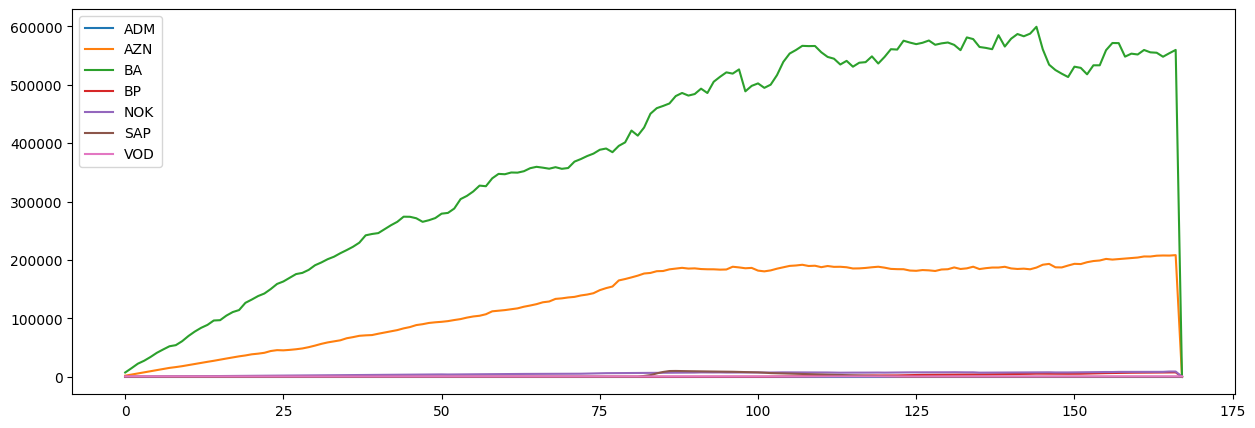

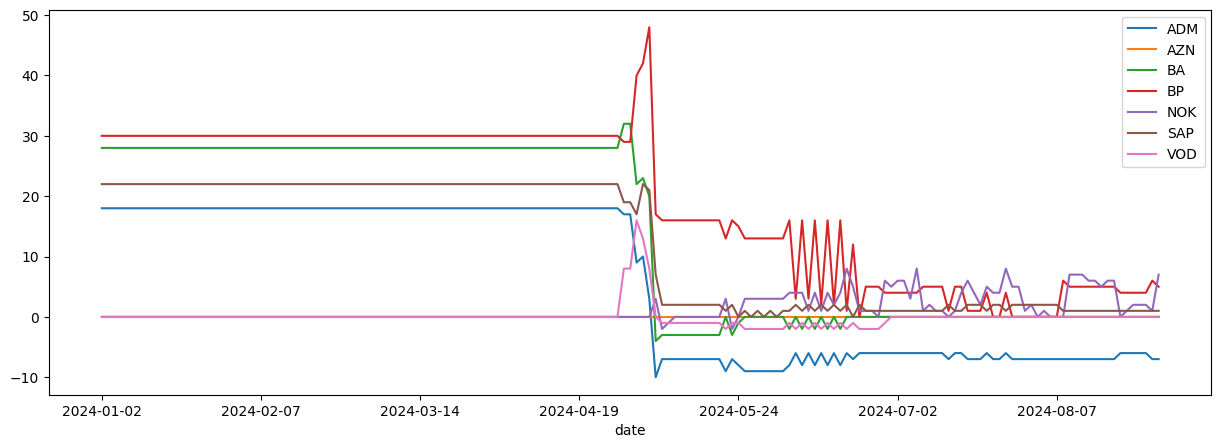

In [130]:
hoding_df.plot()
df_actions_ppo.plot()

In [107]:
a2c_model = agent.get_model("a2c")
trained_a2c = agent.train_model(model=a2c_model, 
                             tb_log_name='a2c',
                             total_timesteps=50000)

{'n_steps': 5, 'ent_coef': 0.01, 'learning_rate': 0.0007}
Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
--------------------------------------
| time/                 |            |
|    fps                | 144        |
|    iterations         | 100        |
|    time_elapsed       | 3          |
|    total_timesteps    | 500        |
| train/                |            |
|    entropy_loss       | -9.99      |
|    explained_variance | 0          |
|    learning_rate      | 0.0007     |
|    n_updates          | 99         |
|    policy_loss        | -14.7      |
|    reward             | 0.05778634 |
|    std                | 1.01       |
|    value_loss         | 2.41       |
--------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 149       |
|    iterations         | 200       |
|    time_elapsed       | 6         |
|    total_timesteps    | 1000   

hit end!


<Axes: xlabel='date'>

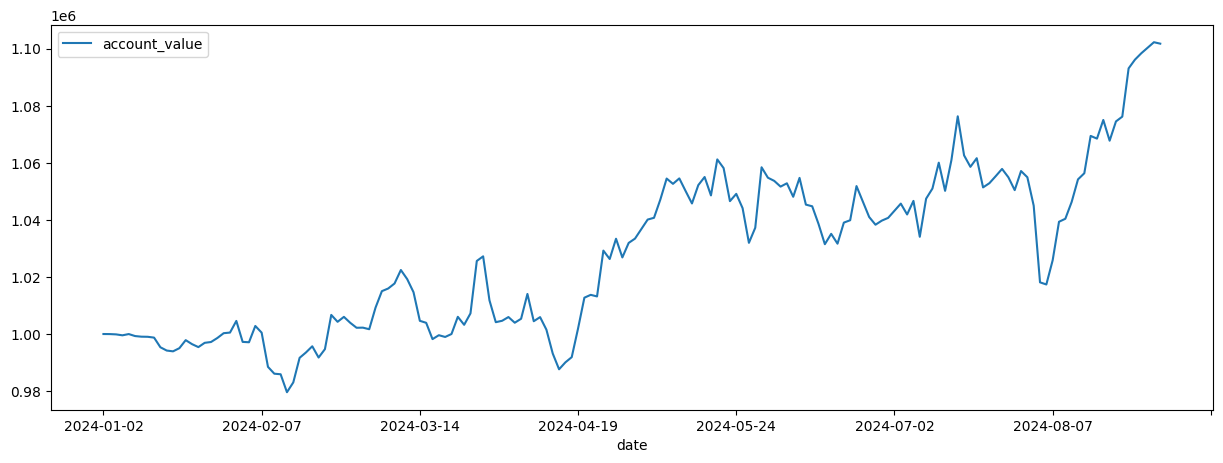

In [31]:

returns,actions = DRLAgent.DRL_prediction(model=trained_a2c, 
                             environment=e_test_gym
                            )
df_a2c = returns.set_index(returns.columns[0])
df_a2c.plot()

hit end!
day: 167, episode: 20
begin_total_asset: 1000000.00
end_total_asset: 1098160.60
total_reward: 98160.60
total_cost: 2630.14
total_trades: 705
Sharpe: 0.802
hit end!


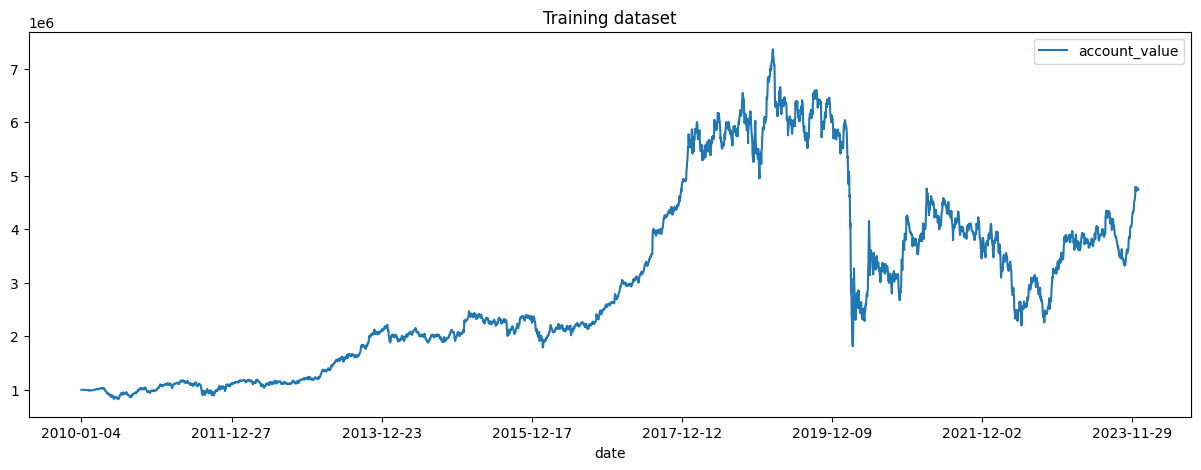

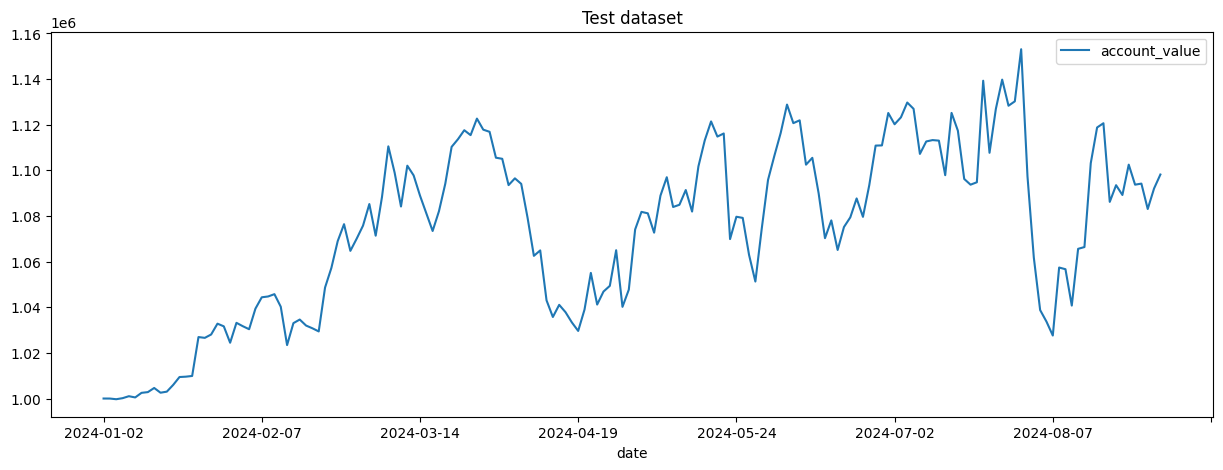

In [136]:
returns,actions,states = DRL_prediction(model=trained_a2c, 
                             environment=e_train_gym
                            )
df_a2c = returns.set_index(returns.columns[0])
df_a2c.plot(title = 'Training dataset')
returns,actions,states_test = DRL_prediction(model=trained_a2c, 
                             environment=e_test_gym
                            )
df_a2c = returns.set_index(returns.columns[0])
ax = df_a2c.plot(title = 'Test dataset')

<Axes: >

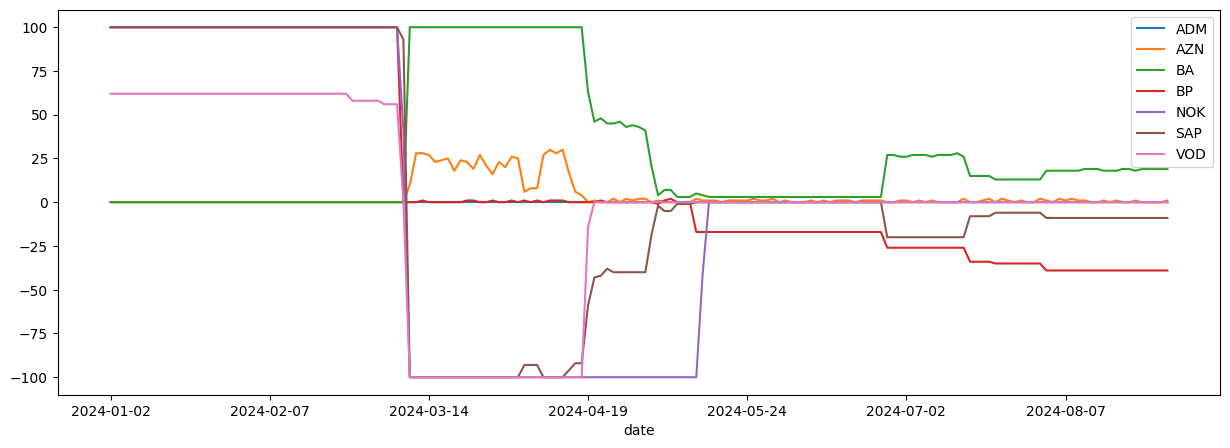

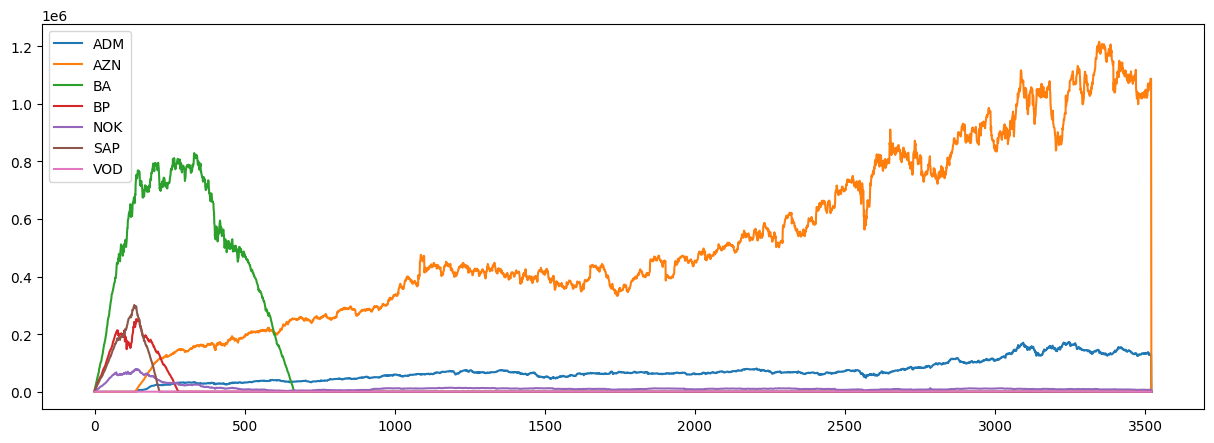

In [139]:

actions.plot()
states = np.array(states)
z2 = pd.DataFrame(states,columns= columns)
holdings = np.array(z2.iloc[:,1:stock_dimension+1]) * np.array(z2.iloc[:,stock_dimension+2 :2*(stock_dimension+1)])
hoding_df2 = pd.DataFrame(holdings,columns=z2.columns[1:stock_dimension+1].tolist())
hoding_df2.plot()
